In [1]:
import os
import sys
import copy
import math
import torch
import random
import syft as sy
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import OrderedDict
sys.path.append(os.getcwd()+'/assistive_functions')

from SMWrapper import SMWrapper
from household import Household, SyNet
from load_data import get_data_of_a_person
from construct_dataset import construct_dataset
from sklearn.model_selection import train_test_split

random.seed(30)
np.random.seed(30)

In [2]:
# candidate lags
def get_lags(step_ahead, num_days=np.array([0,1,7])):
    lags = []
    for i in num_days:
        lags = lags + [48*i, 48*i+1, 48*i+2]
    lags = [x-step_ahead+1 for x in lags if x>=step_ahead]
    return lags

def connect_to_households(household_options):
    # get candidate houses from the selected group
    path = os.getcwd()+"/input/informations_households.csv.xls"
    data = pd.read_csv(path)
    # filter by group
    candidates = data.loc[data.Acorn==household_options['group']]
    # filter by tariff 
    candidates = candidates.loc[candidates.stdorToU==household_options['stdorToU']]
    # print(candidates)    
    # TODO: shuffle
    households=[]
    step_ahead=1

    # create households
    needed = household_options['num_households']
    num = 0
    while needed>0:
        # check if there are enough households
        if num>=len(candidates):
            num_households = len(households)
            print('[Warning] could not find enough households')
            print('[Warning] changed number of households to ' + str(num_households))
        # get household
        household = Household(house_id=candidates.LCLid.iloc[num],
                               block_num=candidates.file.iloc[num])
        # load data with regression options
        household.construct_dataset(lags=get_lags(step_ahead), step_ahead=step_ahead, options=options)
        if len(household.y) > 0:
            households.append(household)
            needed = needed-1
        # search next
        num = num+1

    print('\n[INFO] Connected to ' + str(len(households)) + ' households')
    return households

### Connect to households

In [3]:
# number of devices and their group
num_households = 10
group="ACORN-L"
stdorToU="ToU"
household_options = {"num_households":num_households,
                    "group":group,
                    "stdorToU":stdorToU}

# regression options
options = {"dayparts":[],
           "resolution":60,
           "remove_holiday":True,
           "filt_days":['Tuesday'], 
           "replacement_method":'week_before',
           "feat_cols":['hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'temperature_hourly']}
step_ahead=1

households = connect_to_households(household_options)


[INFO] Connected to 10 households


# Distributed Adam

In [4]:
def print_param(model, message=''):
    with np.printoptions(precision=3, suppress=True):
        print(message+' model: \nbias = ' + 
              str(model.state_dict()['linear.bias'].numpy()[0]) +
              ', \nweights = ' + 
              str(model.state_dict()['linear.weight'].numpy().flatten()))
    return
        
        
def distributed_adam(households, lr, mbsize, total_it, **kwargs):
    if 'init_state_dict' in kwargs:
        set_init = True
        init_state_dict = kwargs.get('init_state_dict')
    else:
        set_init = False
    # create an initial model with random parameters
    in_dim=households[0].info['num_features']
    model = SyNet(torch, in_dim=in_dim, out_dim=1)
    if set_init:
        for key, value in init_state_dict.items():
            model.state_dict()[key].copy_(value)
        print_param(model, 'Initial DA ')
    # create optimizer
    optim = torch.optim.Adam(params=model.parameters(), lr=lr)
    # iterate
    for i in np.arange(math.floor(total_it/mbsize)):
        # initialize param update
        cur_state_dict=copy.deepcopy(model.state_dict())
        new_weights = model.state_dict()['linear.weight'].numpy().flatten()
        new_bias = model.state_dict()['linear.bias'].numpy()
        # run minibatch SGD for each household
        for household in households:
            # run minibatch SGD and get update in parameters
            delta_bias, delta_weight = household.minibatch_SGD(model=model,optim=optim, mbsize=mbsize)
            # aggregate updates
            new_bias = new_bias + delta_bias
            new_weights = new_weights + delta_weight
        # update model
        new_bias = torch.tensor(new_bias)
        new_weights = torch.tensor(new_weights.reshape((1,len(new_weights))))
        model.state_dict()['linear.weight'].copy_(new_weights)
        model.state_dict()['linear.bias'].copy_(new_bias)
        #print_param(model, 'Iteration ' + str(i) + ' ')

        #print(' ')
    # print trained parameters
    print_param(model, 'Trained DA ')
    return model

In [5]:
lr = 0.1
mbsize = 10
total_it = 100

# construct dataset
for household in households:
    household.construct_dataset(lags=get_lags(step_ahead), step_ahead=step_ahead, options=options)
    household.train_test_split(test_frac=0.25)

# train distributed adam
model_s = distributed_adam(households, lr=lr, mbsize=mbsize, total_it=total_it)

Trained DA  model: 
bias = 0.19394255, 
weights = [-0.067 -0.176 -0.109  0.175 -0.323  1.453  0.527  0.484  0.14   0.052
  1.133 -0.265 -0.425]


# Test

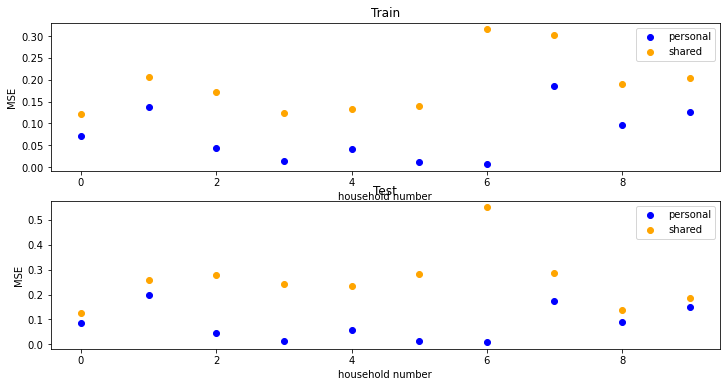

In [6]:
mse_train_p = np.zeros(num_households)
mse_train_s = np.zeros(num_households)
mse_test_p = np.zeros(num_households)
mse_test_s = np.zeros(num_households)

for h_ind, household in enumerate(households):
    # train personal model 
    household.fit_personal_model(method='Adam', lr=lr, iterations=total_it)
    res = household.evaluate_model(method='Adam')
    mse_train_p[h_ind] = res['MSE_train']
    mse_test_p[h_ind] = res['MSE_test']
    # test adam
    res = household.evaluate_model(method='Adam', model=model_s)
    mse_train_s[h_ind] = res['MSE_train']
    mse_test_s[h_ind] = res['MSE_test']
    
fig,axs = plt.subplots(2,1,figsize=(12,6))
axs[0].scatter(np.arange(num_households), mse_train_p, color='blue', label='personal')
axs[0].scatter(np.arange(num_households), mse_train_s, color='orange', label='shared')
axs[0].set_title('Train')
axs[1].scatter(np.arange(num_households), mse_test_p, color='blue', label='personal')
axs[1].scatter(np.arange(num_households), mse_test_s, color='orange', label='shared')
axs[1].set_title('Test')
for ax in axs:
    ax.legend()
    ax.set_xlabel('household number')
    ax.set_ylabel('MSE')
    

# Check
This section is for checking if the distributed Adam algorithm works correctly. To do so, we use only one household and fit a linear regression model with two methods: 1) directly using Adam on the local data of this household, 2) using the distributed Adam by only one household. If initiated at the same parameters, both methods return the same weights and bias. 

In [7]:
lr = 0.1
mbsize = 2
total_it = 400

# create an initial model with random parameters
model = SyNet(torch, in_dim=household.info['num_features'], out_dim=1)
init_state_dict = copy.deepcopy(model.state_dict())
  
# set training data
households[0].train_test_split(test_frac=0.25)    

# METHOD 1
household = households[0]
print('\nMethod 1')
household.fit_personal_model(method='Adam', lr=lr, iterations=total_it, init_state_dict=init_state_dict)
model_lr = household.personal_lr
print_param(model_lr)

# METHOD 2
print('\nMethod 2')
model_da = distributed_adam([household], lr, mbsize, total_it, init_state_dict=init_state_dict)


Method 1
 model: 
bias = 0.1544352, 
weights = [-0.039 -0.01  -0.017 -0.002 -0.063  1.937  0.176  0.532 -0.043 -0.134
  0.057  0.042 -0.042]

Method 2
Initial DA  model: 
bias = -0.116587475, 
weights = [ 0.028  0.173 -0.073  0.094  0.04   0.273 -0.244 -0.137 -0.246 -0.093
 -0.195 -0.149  0.067]
Trained DA  model: 
bias = 0.34830564, 
weights = [ 0.033 -0.017 -0.13  -0.16  -0.664  1.078  0.197  0.34  -0.017  0.007
  0.899 -0.221 -0.229]
